# Sweep N Values

In [1]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig
from numpy import sin
from numpy import pi
from scipy.optimize import curve_fit

In [2]:
L=1
J1=0.1
J2=1
ω=2
U=10*J2
weight=0.1

En estos subalgoritmos definimos los operadores creación y destrucción de bosones:
$$a |n\rangle = \sqrt{n} |n-1\rangle \qquad a^\dagger |n \rangle = \sqrt{n+1} |n+1  \rangle$$

In [3]:
@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False, fastmath=True)
def a(n):
    if n == 0:
        return (0,0)
    else:
        return (n-1, np.sqrt(n))

@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False, fastmath=True)
def a_plus(n):
    return (n+1, np.sqrt(n+1))

In [4]:
#Definimos el producto entre un bra y un ket, si son iguales vale 1 y si son distintos 0
@numba.jit(float64(float64[:],float64[:]), nopython = True, parallel = False, fastmath=True)
def bracket(bra1, ket1):
    if np.all(bra1 == ket1):
        return 1
    else:
        return 0

In [5]:
#Este subalgoritmo calcula un elemento de matriz con un Hamiltoniano 
@numba.jit(float64(float64[:],float64[:],float64, int64, float64), nopython = True, parallel = False)
def Elemento_matriz_Hamiltoniano(bra, ket, U, N, ω):
    #print(bra,ket)
    #<bra|H|ket>
    n_eigval=N*(N+1)/2
    H=0

    ket_aux = np.empty(len(ket))
    ket_aux2 = np.empty(len(ket))
    bra_aux = np.empty(len(ket))

    bracket1 = bracket(bra, ket)

    H += np.sum(ω*ket*bracket1)
    H += np.sum(0.5*U*ket*(ket-1)*bracket1)
    
    ket_aux[:] = ket
    ket_aux2[:] = ket
    bra_aux[:] = bra
    if (N-1)%2==0:
        J=J1
    else:
        J=J2
    ket_aux[0], coef_term2=0,0
    ket_aux[N-1], coef_term2_aux=a_plus(ket_aux[N-1])
    term2 = J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
    ket_aux2[N-1], coef_term3=a(ket_aux2[N-1])
    #P.B.C.
    #ket_aux2[0], coef_term3_aux=a_plus(ket_aux2[0])
    #H.B.C.
    ket_aux2[0], coef_term3_aux=0,0
    term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)
    H+=term2+term3
    for i in range(len(ket)-1):
            ket_aux[:] = ket
            ket_aux2[:] = ket
            bra_aux[:] = bra
            #print("El valor de bra en el subalgoritmo")
            #print(bra)
            #coef_term2=coef_term2_aux=coef_term3=coef_term3_aux=0
            if i%2==0:
                J=J1
            else:
                J=J2
            
            #print("Entro en el else")
            ket_aux[i+1], coef_term2 = a(ket_aux[i+1])
            ket_aux[i], coef_term2_aux=a_plus(ket_aux[i])
            term2=J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
            ket_aux2[i], coef_term3=a(ket_aux2[i])
            ket_aux2[i+1], coef_term3_aux=a_plus(ket_aux2[i+1])
            term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)

            #print(term2, term3)
            H+=term2+term3
    #print("\n")
    return H

In [6]:
@numba.jit(float64[:,:](float64,float64[:,:], int64, float64[:,:]), nopython = True, parallel = False)
def ComputeH(U,base, N, ω_matrix):
    n_eigval=int(N*(N+1)/2)
    H = np.empty((n_eigval,n_eigval))
    for i2 in range(n_eigval):
        for j2 in range(n_eigval):
            H[i2,j2]=Elemento_matriz_Hamiltoniano(base[i2],base[j2], U, N, ω_matrix[i2, j2])
    return H

In [7]:
@numba.jit(float64[:, :](int64, float64, float64, float64[:]), nopython=True, parallel=False)
def FastHamiltonian(N, J1, J2, ω_array):
    #Manera rapida de calcular el Hamiltoniano
    aux_N=int(N/2) #Numero de celdas
    H_int1=np.asarray([[0, 1], [1, 0]])
    aux1=np.kron(np.eye(aux_N), H_int1)
    aux2=np.eye(N, k=1)+np.eye(N, k=-1)-aux1
    aux3=np.zeros((N, N))
    for i in range(N):
        aux3[i, i]=ω_array[i]
    H=J1*aux1+J2*aux2+aux3
    #print(H)
    return H

In [8]:
@numba.jit(numba.types.Tuple((int64[:], int64[:], int64[:], float64[:]))(int64, float64[:]), fastmath=True,  nopython = True, parallel = False)
def ComputeIndexes(N, ω_array):    
    H1p=FastHamiltonian(N, J1, J2, ω_array)
    eigval1p, eigvect1p=eig(H1p)
    idx1p = np.argsort(eigval1p)
    eigval1p = eigval1p[idx1p]
    eigvalNeg=eigval1p[:int(N/2)]
    InterestingIndex=np.argmax(eigvalNeg)
    E_teorIndep=[]
    NumberIterations=0
    IndexEdgeEdge=[]
    IndexBulkEdge=[]
    counter=0
    #Edge_Edge_Energies=[2*eigval1p[InterestingIndex], eigval1p[InterestingIndex]+ eigval1p[InterestingIndex+1], 2*eigval1p[InterestingIndex+1]]
    for i in range(N):
        for j in range (i,N):
            E_teorIndep.append(eigval1p[i]+eigval1p[j])
            if i== InterestingIndex or i==InterestingIndex+1:
                if j== InterestingIndex or j==InterestingIndex+1:
                    IndexEdgeEdge.append(counter)
                else:
                    IndexBulkEdge.append(counter)
            else:
                if j== InterestingIndex or j==InterestingIndex+1:
                    IndexBulkEdge.append(counter)
            counter+=1
    E_teorIndep=np.asarray(E_teorIndep)
    idx=np.argsort(E_teorIndep)
    E_teorIndep=E_teorIndep[idx]
    for i in range(len(IndexEdgeEdge)):
        IndexEdgeEdge[i]=np.argmin(np.abs(idx-IndexEdgeEdge[i]))
    for i in range(len(IndexBulkEdge)):
        IndexBulkEdge[i]=np.argmin(np.abs(idx-IndexBulkEdge[i]))
    IndexBulkBulk=[]
    for k in range(len(E_teorIndep)):
        if k in IndexBulkEdge :
            dummy=1
        elif k in IndexEdgeEdge:
            dummy=2
        else:
            IndexBulkBulk.append(k)
    IndexEdgeEdge=np.asarray(IndexEdgeEdge)
    IndexBulkEdge=np.asarray(IndexBulkEdge)
    IndexBulkBulk=np.asarray(IndexBulkBulk)
    #print(IndexBulkBulk, IndexBulkEdge, IndexEdgeEdge)
    #print(out)
    return (IndexEdgeEdge, IndexBulkEdge, IndexBulkBulk, E_teorIndep)
#ComputeIndexes(10)

In [9]:
@numba.jit(float64[:](float64[:,:]), nopython = True, parallel = False, fastmath=True)
def ComputeParticipationRatio(H):
    #H=Matrix(n_eigval, n_eigval, func_aux)
    #display(H)
    #H=np.array(H).astype(np.float64)
    #eigval, eigvect = np.linalg.eig(H)
    eigval, eigvect = np.linalg.eig(H.astype(np.complex128))
    eigval = np.real(eigval)
    idx = np.argsort(eigval)
    #eigval = list(eigval[idx])
    #No sé cual ess la forma buena
    eigvect = eigvect[:,idx]

    participation_ratio = np.sum(np.abs(eigvect**2), axis = 0) / np.sum(np.abs(eigvect**4), axis = 0)
    #print("PR")
    #print(participation_ratio)
    #if SweepU:
        #return np.amin(participation_ratio)
    #if SweepN:
    return participation_ratio


@numba.jit(numba.types.UniTuple(float64[:], 4)(int64,int64,int64, float64), nopython = True, fastmath=True,  parallel =False)
def SweepNSubalg(N_min, N_max, salto, U):

    N_array=np.arange(N_min,N_max,salto)
    N_points=len(N_array)
    AverageDoublon=np.zeros((N_points))
    MinDoublon=np.zeros((N_points))
    MinScattering=np.zeros((N_points))
    SigmaDoublon=np.zeros((N_points))
    for i in range(N_points):
        n=N_array[i]
        PR_array=np.zeros(n)
        n_eigval=int(n*(n+1)/2)
        SweepNMatrix = np.zeros((n_eigval,n_eigval))
        #print(n)
        Identity=np.identity(n)
        base=np.empty((n_eigval, n))
        counter=0
        for l in range(n):
            for k in range(l,n):
                ketB=Identity[k,:]+Identity[l,:]
                #print(ketB)
                base[counter, :]=ketB
                counter+=1
        #base=base.astype('int64')
        #print(base)
        ω_array=ω*(1+2*weight*(np.random.rand(n)-0.5))
        ω_matrix=np.zeros((n_eigval, n_eigval))
        counter=0
        for l in range(n):
            for k in range(l,n):
                ω_matrix[counter, counter]=(ω_array[l]+ω_array[k])/2
                counter+=1
        SweepNMatrix=ComputeH(U, base, n, ω_matrix)
        PR_array=ComputeParticipationRatio(SweepNMatrix)
        #IndexEdgeEdgeN, IndexBulkEdgeN, IndexBulkBulkN, trash=ComputeIndexes(n, ω_array)
        IndexDoublon=np.arange(int(n*(n+1)/2)-n, int(n*(n+1)/2))
        IndexScattering=np.arange(0, int(n*(n+1)/2)-n)
        #print(IndexEdgeEdgeN, IndexBulkEdgeN, IndexBulkBulkN)
        AverageDoublon[i]=np.mean(PR_array[IndexDoublon])
        SigmaDoublon[i]=np.std(PR_array[IndexDoublon])
        MinDoublon[i]=(np.min(PR_array[IndexDoublon]))
        #SigmaBE[i]=(np.std(PR_array[IndexBulkEdgeN]))
        MinScattering[i]=np.min(PR_array[IndexScattering])
        #SigmaEE[i]=np.std(PR_array[IndexEdgeEdgeN])
        #print(AverageBulkBulk, AverageBulkEdge, MinBulkBulk, MaxEdgeEdge, MinEdgeEdge)
    #print(AverageBulkBulk)
    return (AverageDoublon, SigmaDoublon, MinDoublon, MinScattering)
      
    

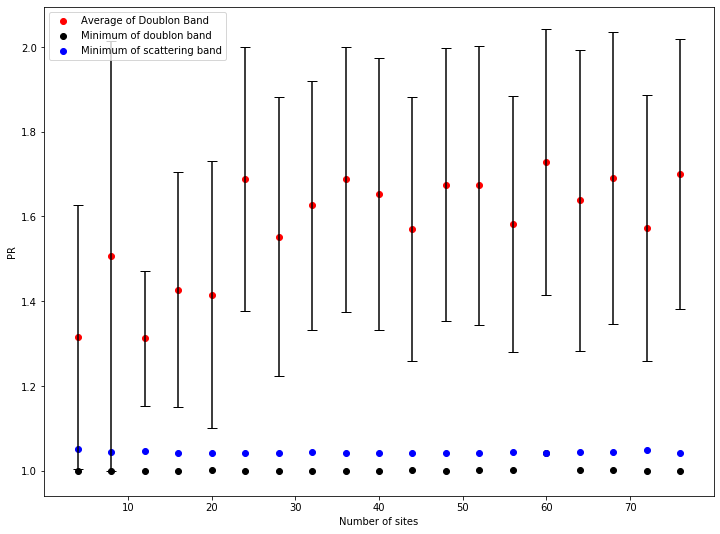

In [10]:
N_min=4
N_max=80
deltaN=4
N_array=np.arange(N_min, N_max, deltaN)
#print(N_array)
AverageDoublon, SigmaDoublon, MinDoublon, MinScattering=SweepNSubalg(N_min, N_max, deltaN, U) 
fig=plt.figure(figsize=[12, 9])
plt.errorbar(N_array, AverageDoublon, yerr=SigmaDoublon, color='black', capsize=5, linestyle='None')
plt.scatter(N_array, AverageDoublon, color='red', label="Average of Doublon Band")
plt.scatter(N_array, MinDoublon, color='black', label="Minimum of doublon band")
plt.scatter(N_array, MinScattering, color='blue', label="Minimum of scattering band")
plt.legend()
plt.xlabel("Number of sites")
plt.ylabel("PR")
#plt.yscale('log')
#plt.xscale('log')
plt.show()

In [11]:
def func(N, a, b, c):
    return a*N**2+b*N+c
poptBB, pcovBB=curve_fit(func, N_array, AverageBulkBulk,p0=[1,1,0], sigma=SigmaBB)
poptBE, pcovBE=curve_fit(func, N_array, AverageBulkEdge,p0=[1,1,0], sigma=SigmaBE)
poptEE, pcovEE=curve_fit(func, N_array, AverageEdgeEdge,p0=[1,1,0], sigma=SigmaEE)
print("Quadratic Fit to the average bulk-bulk PR values aN^2+bN+c with errors")
print("a \t \t b \t \t  c")
print(poptBB)
print(np.sqrt(pcovBB[0,0]), np.sqrt(pcovBB[1, 1]), np.sqrt(pcovBB[2, 2]))
print("\n Quadratic Fit to the average bulk-edge PR values aN^2+bN+c with errors")
print("a \t \t b \t \t  c")
print(poptBE)
print(np.sqrt(pcovBE[0,0]), np.sqrt(pcovBE[1, 1]), np.sqrt(pcovBE[2, 2]))
print("\n Quadratic Fit to the average edge-edge PR values aN^2+bN+c with errors")
print("a \t \t b \t \t  c")
print(poptEE)
print(np.sqrt(pcovEE[0,0]), np.sqrt(pcovEE[1, 1]), np.sqrt(pcovEE[2, 2]))
#np.savetxt('dataStrange.txt', np.column_stack((AverageBulkBulk, MinBulkBulk, AverageBulkEdge, MaxEdgeEdge, MinEdgeEdge)), delimiter=' ')
fig=plt.figure(figsize=[12, 9])
plt.errorbar(N_array, AverageBulkBulk, yerr=SigmaBB, color='red', capsize=5, linestyle='None')
plt.errorbar(N_array, AverageBulkEdge, yerr=SigmaBE, color='black', capsize=5, linestyle='None')
plt.errorbar(N_array, AverageEdgeEdge, yerr=SigmaEE, color='blue', capsize=5, linestyle='None')
plt.scatter(N_array, AverageBulkBulk, color='red', label="Average of Bulk-Bulk")
plt.scatter(N_array, AverageBulkEdge, color='black', label="Average of Bulk-Edge")
plt.scatter(N_array, AverageEdgeEdge, color='blue', label="Average of Edge-Edge")
plt.plot(N_array, func(N_array, poptBB[0], poptBB[1], poptBB[2]), color='red', label="Fit of Bulk-Bulk")
plt.plot(N_array, func(N_array, poptBE[0], poptBE[1], poptBE[2]), color='black', label="Fit of Bulk-Edge")
plt.plot(N_array, func(N_array, poptEE[0], poptEE[1], poptEE[2]), color='blue', label="Fit of Edge-Edge")
plt.legend()
plt.xlabel("Number of sites")
plt.ylabel("PR")
plt.ylim(0,)
plt.title("Fit of the PR values versus the number of sites for ω="+str(ω)+" with a perturbation of Δω="+str(weight*100)+"% \n with J1="+str(J1)+" J2="+str(J2)+" and U="+str(U))
plt.savefig('SSH_FitPRvsN.png')
#plt.yscale('log')
#plt.xscale('log')
plt.show()

NameError: name 'AverageBulkBulk' is not defined

In [ ]:
print(MinBulkBulk)

In [ ]:
"""BigArray=[]
a=np.asarray([[1, 0], [0, 1]])
b=np.asarray([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
BigArray.append(a)
BigArray.append(b)
BigArray=np.asarray(BigArray)
print(BigArray[0])"""

In [ ]:
#print(AverageBulkBulk, SigmaBB)
#print(AverageBulkEdge, SigmaBE)
print(AverageEdgeEdge, SigmaEE)

In [ ]:
""" N_array=np.arange(N_min,N_max,salto)
    N_points=len(N_array)
    AverageBulkBulk=np.zeros((N_points))
    AverageBulkEdge=np.zeros((N_points))
    AverageEdgeEdge=np.zeros((N_points))
    SigmaBB=np.zeros((N_points))
    SigmaBE=np.zeros((N_points))
    SigmaEE=np.zeros((N_points))
    for i in range(N_points):
        n=N_array[i]
        PR_array=np.zeros(n)
        n_eigval=int(n*(n+1)/2)
        SweepNMatrix = np.zeros((n_eigval,n_eigval))
        #print(n)
        Identity=np.identity(n)
        base=np.empty((n_eigval, n))
        counter=0
        for l in range(n):
            for k in range(l,n):
                ketB=Identity[k,:]+Identity[l,:]
                #print(ketB)
                base[counter, :]=ketB
                counter+=1
        #base=base.astype('int64')
        #print(base)
        ω_array=ω*(1+2*weight*(np.random.rand(n)-0.5))
        ω_matrix=np.zeros((n_eigval, n_eigval))
        counter=0
        for l in range(n):
            for k in range(l,n):
                ω_matrix[counter, counter]=(ω_array[l]+ω_array[k])/2
                counter+=1
        SweepNMatrix=ComputeH(U, base, n, ω_matrix)
        PR_array=ComputeParticipationRatio(SweepNMatrix)
        IndexEdgeEdgeN, IndexBulkEdgeN, IndexBulkBulkN, trash=ComputeIndexes(n, ω_array)
        #print(IndexEdgeEdgeN, IndexBulkEdgeN, IndexBulkBulkN)
        AverageBulkBulk[i]=np.mean(PR_array[IndexBulkBulkN])
        SigmaBB[i]=np.std(PR_array[IndexBulkBulkN])
        AverageBulkEdge[i]=(np.mean(PR_array[IndexBulkEdgeN]))
        SigmaBE[i]=(np.std(PR_array[IndexBulkEdgeN]))
        AverageEdgeEdge[i]=np.mean(PR_array[IndexEdgeEdgeN])
        SigmaEE[i]=np.std(PR_array[IndexEdgeEdgeN])
        #print(AverageBulkBulk, AverageBulkEdge, MinBulkBulk, MaxEdgeEdge, MinEdgeEdge)
    #print(AverageBulkBulk)
    return (AverageBulkBulk, SigmaBB, AverageBulkEdge, SigmaBE, AverageEdgeEdge, SigmaEE)
    """